In [76]:
# !unzip -n "DATA/classification-of-short-noisy-audio-speech.zip" -d "DATA/"
# !unzip -n "/home/ipynb/notebooks/wav2vec2/DATA/train_not_noise.zip" -d "/home/ipynb/notebooks/wav2vec2/DATA/"

# 1. Загрузка и установка бибилотек. Установка параметров

In [59]:
# !pip install transformers
# !pip install librosa
# !pip install datasets
# !pip install nlpaug
# !git clone https://github.com/facebookresearch/denoiser
# !pip install julius

In [1]:
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
import librosa
import librosa.display as librosa_display
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset, load_metric, Dataset, DatasetDict
import random
from IPython.display import display, Audio
from transformers import AutoFeatureExtractor
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import os
# from google.colab import files, drive
import soundfile as sf
import torch
from pathlib import Path
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

In [2]:
# drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
params = SimpleNamespace()
params.sr = 16000 #sample rate
params.model_chekpoint = "OthmaneJ/distil-wav2vec2"
params.batch_size = 32
params.max_duration = 1.0
params.PATH_TO_NOISE = '/home/ipynb/notebooks/wav2vec2/DATA/hackaton_ds/train/'
params.PATH_NOT_NOISE = '/home/ipynb/notebooks/wav2vec2/DATA/train/'

params.PATH_TEST = '/home/ipynb/notebooks/wav2vec2/DATA/hackaton_ds/test'
params.PATH_NOT_NOISE_TEST = '/home/ipynb/notebooks/wav2vec2/DATA/test/'

params.SAVE_PATH = '/home/ipynb/notebooks/wav2vec2/DATA/'
params.CLASS_NAMES2ID = {'yes':0, 'no':1, 'up':2, 'down':3, 'left':4, 'right':5, 'on':6, 'off':7, 'stop':8, 'go':9}
params.ID2CLASS_NAMES = {0:'yes', 1:'no', 2:'up', 3:'down', 4:'left', 5:'right', 6:'on', 7:'off', 8:'stop', 9:'go'}

# 2. Загрузка и обработка данных

## 2.1. Очистка файлов от шума

In [70]:
# %cd ./denoiser

In [69]:
# for class_folder in tqdm_notebook(os.listdir(params.PATH_NOT_NOISE)):
#     dir_noise = params.PATH_NOT_NOISE + class_folder
#     dir_not_noise = params.PATH_NOT_NOISE + class_folder
#     !python -m denoiser.enhance --master64 --noisy_dir=$dir_noise --out_dir=$dir_not_noise --device 'cuda'

## 2.2. Загрузка файлов из папки

In [4]:
def load_audiodata(load_path):
    audio_dataset = {}            
    for class_files in tqdm_notebook(os.listdir(load_path)):     
        for audio_file in tqdm_notebook(os.listdir(os.path.join(load_path, class_files))):
            # if 'enhanced.wav' in (audio_file.split('_')):
            array_file, _ = librosa.load(os.path.join(load_path, class_files, audio_file), sr=16000)
            if class_files in params.CLASS_NAMES2ID.keys():
                label_audio = params.CLASS_NAMES2ID[class_files]
            elif class_files == '_background_noise_':
                label_audio = params.CLASS_NAMES2ID['_silence_']
            else:
                label_audio = params.CLASS_NAMES2ID['_unknown_']
            try:
                audio_dataset['input_values'].append(array_file)
                audio_dataset['label'].append(label_audio)
            except:
                audio_dataset['input_values'] = [array_file]
                audio_dataset['label'] = [label_audio]                
    return audio_dataset

In [5]:
train_dataset = load_audiodata(params.PATH_TO_NOISE)

<ipython-input-4-3b8cf3756cb1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for class_files in tqdm_notebook(os.listdir(load_path)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-4-3b8cf3756cb1>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for audio_file in tqdm_notebook(os.listdir(os.path.join(load_path, class_files))):


  0%|          | 0/8895 [00:00<?, ?it/s]

  0%|          | 0/8875 [00:00<?, ?it/s]

  0%|          | 0/8820 [00:00<?, ?it/s]

  0%|          | 0/8875 [00:00<?, ?it/s]

  0%|          | 0/8910 [00:00<?, ?it/s]

  0%|          | 0/8925 [00:00<?, ?it/s]

  0%|          | 0/8905 [00:00<?, ?it/s]

  0%|          | 0/8835 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8905 [00:00<?, ?it/s]

In [6]:
train_dataset = Dataset.from_dict(train_dataset)

## 2.3. Загруза из датасета

In [ ]:
dataset = load_dataset("superb", "ks")
metric = load_metric("accuracy")

Reusing dataset superb (/root/.cache/huggingface/datasets/superb/ks/1.9.0/fc1f59e1fa54262dfb42de99c326a806ef7de1263ece177b59359a1a3354a9c9)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# LabelEncoder кодирует в своем порядке, отличном от словаря
labels = dataset["train"].features["label"].names
l2id, id2l = dict(), dict()
for i, label in enumerate(labels):
    l2id[label] = str(i)
    id2l[str(i)] = label

In [ ]:
for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"]) - 1)
    example = dataset["train"][rand_idx]
    audio = example["audio"]
    print(f'Label: {id2l[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling_rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: _unknown_
Shape: (16000,), sampling_rate: 16000



Label: down
Shape: (16000,), sampling_rate: 16000



Label: _unknown_
Shape: (16000,), sampling_rate: 16000



Label: _unknown_
Shape: (16000,), sampling_rate: 16000



Label: up
Shape: (16000,), sampling_rate: 16000


## 2.4. Преобразование данных в наборы для обучения

In [7]:
metric = load_metric("accuracy")
feature_extractor = AutoFeatureExtractor.from_pretrained(params.model_chekpoint)
params.sr = feature_extractor.sampling_rate
feature_extractor

/opt/anaconda3/envs/zhuk/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [8]:
def preprocess_function(examples):
    audio_arrays = [x for x in examples["input_values"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=params.sr,
        max_length = int(params.sr * params.max_duration),
        truncation=True,
    )
    return inputs

In [9]:
# load_from_cache_file=False
train_dataset = train_dataset.map(preprocess_function, batched=True)
train_dataset

  0%|          | 0/89 [00:00<?, ?ba/s]

/opt/anaconda3/envs/zhuk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Dataset({
    features: ['input_values', 'label'],
    num_rows: 88790
})

In [10]:
train_dataset.to_csv(params.SAVE_PATH+'train_dataset_with_noise.csv')

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

7637789

## 2.5. Аугментация данных

In [ ]:
def get_augmentated_data(dict_to_aug, aug_feature, shuffle=True, random_opt=False):
    aug_dict = dict()
    # get keys
    features_list = list(dict_to_aug.keys())
    features_list.remove(aug_feature)
    length = len(dict_to_aug[aug_feature])
    # iterration of x element of dict
    for idx, x in tqdm(enumerate(dict_to_aug[aug_feature]), total=length):
        x_aug_list = [x]
        x = np.array(x)
        
        if random_opt:
            rnd = random.randint(0, 3)
            if rnd == 0:
                aug = naa.CropAug(sampling_rate=params.sr)
                x_aug = aug.augment(x)
            elif rnd == 1:
                aug = aug = naa.LoudnessAug()
                x_aug = aug.augment(x)
            elif rnd == 2:
                aug = naa.MaskAug(sampling_rate=params.sr, mask_with_noise=False)
                x_aug = aug.augment(x)
            elif rnd == 3:
                aug = naa.NoiseAug()
                x_aug = aug.augment(x)
            x_aug_list.append(list(x_aug))
        else:
            aug = naa.CropAug(sampling_rate=params.sr)
            x_aug = aug.augment(x)
            x_aug_list.append(list(x_aug))

            aug = naa.LoudnessAug()
            x_aug = aug.augment(x)
            x_aug_list.append(list(x_aug))

            aug = naa.MaskAug(sampling_rate=params.sr, mask_with_noise=False)
            x_aug = aug.augment(x)
            x_aug_list.append(list(x_aug))

            aug = naa.NoiseAug()
            x_aug = aug.augment(x)
            x_aug_list.append(list(x_aug))
        try:
            aug_dict[aug_feature].extend(x_aug_list)
        except:
            aug_dict[aug_feature] = x_aug_list

        for feture in features_list:
            aug_feture = np.repeat(dict_to_aug[feture][idx], len(x_aug_list))
            try:
                aug_dict[feture].extend(list(aug_feture))
            except:
                aug_dict[feture] = list(aug_feture)
    aug_dict = Dataset.from_dict(aug_dict)
    if shuffle:
        aug_dict.shuffle()
    return aug_dict

In [ ]:
test_dict = dict()
test_dict['input_values'] = encoded_dataset['test']['input_values']
test_dict['label'] = encoded_dataset['test']['label']

In [ ]:
test_dataset = get_augmentated_data(test_dict, 'input_values', shuffle=True, random_opt=False)

100%|██████████| 3081/3081 [00:30<00:00, 100.53it/s]


# 3. Обучение

In [11]:
num_labels = len(params.CLASS_NAMES2ID)
model = AutoModelForAudioClassification.from_pretrained(
    params.model_chekpoint,
    num_labels=num_labels,
    label2id=params.CLASS_NAMES2ID,
    id2label=params.ID2CLASS_NAMES,
)

Some weights of the model checkpoint at OthmaneJ/distil-wav2vec2 were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at OthmaneJ/distil-wav2vec2 and are newly initialized: ['projector.weight', 'classifier.bias', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

In [12]:
model_name = params.model_chekpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-ks-noised",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 3e-5,
    per_device_train_batch_size=params.batch_size,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size=params.batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    lr_scheduler_type = "constant_with_warmup"
    # push_to_hub=True,
)

In [13]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [15]:
trainer.train()

***** Running training *****
  Num examples = 88790
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 6930


Epoch,Training Loss,Validation Loss,Accuracy
0,0.901900,0.463738,0.905733
1,0.630300,0.222153,0.932673
2,0.478500,0.177349,0.942730
3,0.443800,0.154681,0.949544
4,0.418000,0.130157,0.955536
5,0.399900,0.118840,0.959883
6,0.391000,0.109517,0.962023
7,0.364200,0.097164,0.966595
8,0.365200,0.092437,0.967474
9,0.293200,0.084123,0.971089


***** Running Evaluation *****
  Num examples = 88790
  Batch size = 32
Saving model checkpoint to distil-wav2vec2-finetuned-ks-noised/checkpoint-693
Configuration saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-693/config.json
Model weights saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-693/pytorch_model.bin
Configuration saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-693/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 88790
  Batch size = 32
Saving model checkpoint to distil-wav2vec2-finetuned-ks-noised/checkpoint-1386
Configuration saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-1386/config.json
Model weights saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-1386/pytorch_model.bin
Configuration saved in distil-wav2vec2-finetuned-ks-noised/checkpoint-1386/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 88790
  Batch size = 32
Saving model checkpoint to distil-wav2vec2-finetuned-ks-noised/checkpo

TrainOutput(global_step=6930, training_loss=0.5722140165634485, metrics={'train_runtime': 14869.7412, 'train_samples_per_second': 59.712, 'train_steps_per_second': 0.466, 'total_flos': 4.435710284543616e+18, 'train_loss': 0.5722140165634485, 'epoch': 10.0})

In [ ]:
# !zip -r /content/drive/MyDrive/tvneurotech/chekpoints/checkpoint-2444.zip /content/distil-wav2vec2-finetuned-ks/checkpoint-2444

In [ ]:
# !zip -r /content/drive/MyDrive/tvneurotech/chekpoints/checkpoint-3055.zip /content/distil-wav2vec2-finetuned-ks/checkpoint-3055

In [ ]:
# trainer.evaluate()

# 6. Получение предсказаний модели

In [65]:
# %cd /content/denoiser/

In [64]:
# dir_noise = params.PATH_TEST
# dir_not_noise = params.PATH_NOT_NOISE_TEST
# !python -m denoiser.enhance --master64 --noisy_dir=$dir_noise --out_dir=$dir_not_noise --device 'cuda'

In [16]:
sample_csv = pd.read_csv(params.SAVE_PATH + 'sample.csv')
sample_csv

,id,category
0,5d03214e74f5ea475b22,yes
1,686ad9e641964142b6b0,yes
2,eec1364a587997161bb8,yes
3,8fb7ede79446ad22c60f,yes
4,de573903106ba3524064,yes
...,...,...
29615,05ae7715e1499b5a72c8,yes
29616,2e14d09dad51733d4658,yes
29617,267a9b10c2a33d67f084,yes
29618,341143991403fd8ae3c6,yes


In [ ]:
def load_audiodata_for_submit(load_path):
    audio_dataset = {}   
    for audio_file in tqdm_notebook(os.listdir(load_path)):
        #if 'enhanced.wav' in (audio_file.split('_')):
        array_file, _ = librosa.load(os.path.join(load_path, audio_file), sr=16000)        
        try:
            audio_dataset['input_values'].append(array_file)
            audio_dataset['id'].append(audio_file.split('.')[0])           
        except:
            audio_dataset['input_values'] = [array_file]
            audio_dataset['id'] = [audio_file.split('.')[0]]                           
    return audio_dataset

pred_data = load_audiodata_for_submit(params.PATH_TEST)

def preprocess_function2(examples):
    audio_arrays = [x for x in examples]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * params.max_duration), 
        truncation=True, 
    )
    return inputs

pred_data['input_values'] = preprocess_function2(pred_data['input_values'])['input_values']

pred_data_for_model = Dataset.from_dict(pred_data)
dict_predict = trainer.predict(pred_data_for_model)
pred_data['predict'] = np.argmax(dict_predict.predictions, axis=1)
pd_pred_data = pd.DataFrame.from_dict(pred_data)
pd_pred_data['category'] = pd_pred_data.predict.apply(lambda x: params.ID2CLASS_NAMES[x])
pd_pred_data.drop(labels=['input_values', 'predict'], axis=1).to_csv(params.SAVE_PATH + 'submission.csv', index=False)

<ipython-input-19-9dd33bad00c1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for audio_file in tqdm_notebook(os.listdir(load_path)):


  0%|          | 0/29620 [00:00<?, ?it/s]

# Остатки

In [ ]:
!zip -r /content/wav2vec2-base-finetuned-ks/checkpoint-1995.zip /content/wav2vec2-base-finetuned-ks/checkpoint-1995

  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/ (stored 0%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/training_args.bin (deflated 48%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/optimizer.pt (deflated 9%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/config.json (deflated 66%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/pytorch_model.bin (deflated 7%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/trainer_state.json (deflated 85%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/preprocessor_config.json (deflated 33%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/scheduler.pt (deflated 50%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/rng_state.pth (deflated 28%)


In [ ]:
from google.colab import files
files.download("/content/wav2vec2-base-finetuned-ks/checkpoint-1995.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !git clone https://github.com/facebookresearch/denoiser
# !pip install julius

In [ ]:
import soundfile as sf
y = dataset['train'][10]['audio']['array']
sf.write('/content/noised/stereo_file.wav', y, 16000, 'PCM_24')

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cd /content/denoiser/
!python -m denoiser.enhance --master64 --noisy_dir='/content/noised/' --out_dir '/content/not_noised/' --device device

INFO:denoiser.pretrained:Loading pre-trained real time H=64 model trained on DNS and Valentini.
INFO:__main__:Generate enhanced files | 1/1 | 16.7 it/sec
Waiting for pending jobs...
INFO:__main__:Generate enhanced files | 1/1 | 2.3 it/sec


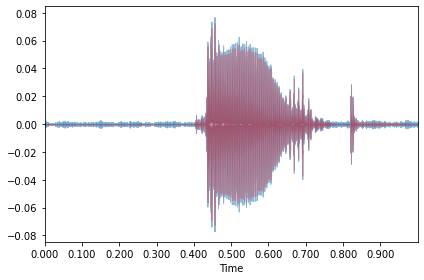

In [ ]:
y, sr = librosa.load('/content/noised/stereo_file.wav', sr=16000)
librosa_display.waveplot(y, sr=sr, alpha=0.5)
y, sr = librosa.load('/content/not_noised/stereo_file_enhanced.wav', sr=16000)
librosa_display.waveplot(y, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

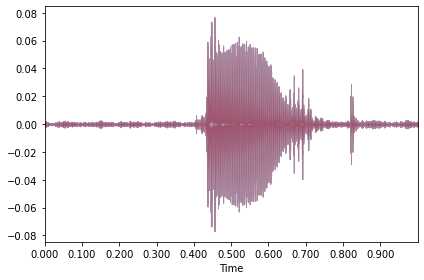

In [ ]:
y, sr = librosa.load('/content/noised/stereo_file.wav')
librosa_display.waveplot(y, sr=sr, alpha=0.5)
y, sr = librosa.load('/content/not_noised/stereo_file_noisy.wav')
librosa_display.waveplot(y, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()